In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load sampling results
sampling_results = pd.read_excel('./results/yeast/sampling_results.xlsx', sheet_name='reactions - all')

# Load gene information
genes_df = pd.read_excel('./results/yeast/sampling_results.xlsx', sheet_name='genes - all')
genes_df = genes_df.set_index('gene')
genes_df.index = pd.Series(genes_df.index).fillna(method='ffill')

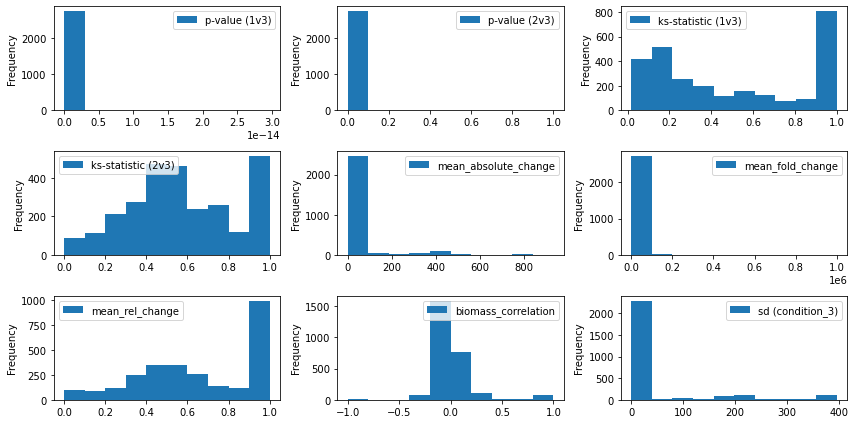

In [3]:
# Check distributions of filtering parameters
# These graphs can guide the selection of filtering parameters
filtering_parameters = [
    'p-value (1v3)', # p-value growth and production scenarios
    'p-value (2v3)', # p-value slow growth and production scenarios
    'ks-statistic (1v3)', # overlap growth and production scenarios
    'ks-statistic (2v3)', # overlap slow growth and production scenarios
    'mean_absolute_change', # absolue flux change between growrh and production scenarios
    'mean_fold_change', # fold flux change between growrh and production scenarios
    'mean_rel_change', # flux relative change between growrh and production scenarios
    'biomass_correlation', # additional to ks (2v3)
    'sd (condition_3)' # std of flux distribution in production scenario
]

fig, axs = plt.subplots(3, 3, figsize=(12,6), tight_layout=True)
for parameter, ax in zip(filtering_parameters, axs.flat):
    sampling_results.plot(x='reaction', y=parameter, kind="hist", ax=ax)


In [4]:
# Filtering
# Filtering based on ks (1v3), ks (2v3), mean_absolute_change and sd (condition_3) is recommended
# Other filtering parameters in filtering_parameters might be additionally used
filtered_results = sampling_results.copy()[
    (sampling_results['ks-statistic (1v3)']>=0.75) &
    (sampling_results['ks-statistic (2v3)']>=0.75) &
    (sampling_results['mean_absolute_change']>=0.01) &
    (sampling_results['sd (condition_3)']<=50) 
].set_index('reaction')

# Summary of number of targets
print(f"KD: before filter = {len(sampling_results[sampling_results['intervention']=='knock-down'])}, after filter = {len(filtered_results[filtered_results['intervention']=='knock-down'])}")
print(f"KO: before filter = {len(sampling_results[sampling_results['intervention']=='knock-out'])}, after filter = {len(filtered_results[filtered_results['intervention']=='knock-out'])}")
print(f"OV: before filter = {len(sampling_results[sampling_results['intervention']=='over-expression'])}, after filter = {len(filtered_results[filtered_results['intervention']=='over-expression'])}")

KD: before filter = 162, after filter = 11
KO: before filter = 290, after filter = 30
OV: before filter = 1266, after filter = 50


In [5]:
# Check possible off-targets
# Check if genes are involved in additional reactions which could lead
# to off-targets during in vivo implementation

def separate_genes(element):
    element = element.replace('(', '').replace(')', '')
    
    if ' and ' in element:
        genes = element.split(' and ')
        return [gene for sub_element in genes for gene in separate_genes(sub_element)]
    elif ' or ' in element:
        return element.split(' or ')
    else:
        return [element]
    
multiple_reactions = []
for gene_rule in filtered_results['gene_rule']: 
    if isinstance(gene_rule, str):
        genes = separate_genes(gene_rule)
        associated_reactions = []
        for gene in genes:
            if isinstance(genes_df.loc[gene]['reaction'], pd.Series):
                if len(associated_reactions) == 0:
                    associated_reactions = list(genes_df.loc[gene]['reaction'])
                else:
                    associated_reactions = associated_reactions + list(genes_df.loc[gene]['reaction'])
            else:
                associated_reactions.append(genes_df.loc[gene]['reaction'])
        multiple_reactions.append(list(set(associated_reactions)))
    else:
        multiple_reactions.append(np.nan)

filtered_results['Possible off-targets'] = multiple_reactions

In [6]:
# Save filtered results

# We can choose whether the filtered output contains columns for all parameters or if it simplified
# Columns to skip in output
summary = True

skip_output_columns = {
    "biomass_correlation",
    "condition_1",
    "condition_2",
    "condition_3",
    "gene_names",
    "ks-statistic (1v2)",
    "ks-statistic (1v3)",
    "ks-statistic (2v3)",
    "mean (condition_2)",
    "p-value (1v2)",
    "p-value (1v3)",
    "p-value (2v3)",
    "sd (condition_2)",
    "significant",
    "target_correlation",
}
column_mapper = {
    "mean (condition_1)": "growing (mean)",
    "sd (condition_1)": "growing (sd)",
    "mean (condition_3)": "producing (mean)",
    "sd (condition_3)": "producing (sd)",
}

with pd.ExcelWriter("./results/yeast/filtered_results.xlsx") as excelwriter:
    if summary:
        output_frame = filtered_results.loc[
            :, filtered_results.columns.difference(skip_output_columns)
        ].rename(columns=column_mapper)
    else:
        output_frame = filtered_results
    
    # Knock-down/out targets
    output_frame[
        (output_frame['intervention']=='knock-down') | (output_frame['intervention']=='knock-out')
    ].sort_values('mean_absolute_change', ascending=False).to_excel(
        excelwriter, sheet_name = 'Down-regulations'
    )
    # Over-expression targets
    output_frame[
        (output_frame['intervention']=='over-expression')
    ].sort_values('mean_absolute_change', ascending=False).to_excel(
        excelwriter, sheet_name = 'Over-expressions'
    )

### Additional filtering

In [17]:
kd = pd.read_excel('filtered_results.xlsx', sheet_name='Down-regulations').set_index('reaction')

In [7]:
# Additional filtering: proteomics data

# Proteins detected by Costenoble
costenoble = pd.read_excel(
    './example_data/proteomics_data.xlsx', 
    sheet_name='Costenoble_2011')
costenoble = costenoble[costenoble['Was the protein observed?']==1]['ORF']
# Proteins detected by Lahtvee
lahtvee = pd.read_excel(
    './example_data/proteomics_data.xlsx', 
    sheet_name='Lahtvee_2017')
lahtvee = lahtvee.dropna()['ORF']

# Relevant detected proteins are those included in the model
detected_prot = list(set(list(costenoble)+list(lahtvee)))
detected_prot = list(set(detected_prot).intersection(genes_df.index))

# Translate to reactions
detected_reac = list(set(genes_df.loc[detected_prot]['reaction']))



In [20]:
# It only makes sense to KD/KO reactions if the corresponding protein is expressed
# i.e. if it is detected in the proteomics datasets
print(f'Original kd targets: {len(kd)}')
detected_reac_kd = []
for reaction in kd.index:
    if reaction in detected_reac:
        detected_reac_kd.append(reaction)
print(f'Kd targets considering proteomics data: {len(detected_reac_kd)}')
kd.loc[detected_reac_kd]

Original kd targets: 41
Kd targets considering proteomics data: 34


Possible off-targets  \
reaction                                                                                                                   
r_1245                                                                                              ['r_3961', 'r_1245']   
r_0438                                                                ['r_0002', 'r_0004', 'r_0439', 'r_0438', 'r_0001']   
r_0770                                                                                                        ['r_0770']   
r_0439                                                                ['r_0002', 'r_0004', 'r_0439', 'r_0438', 'r_0001']   
r_0226                                                                                                        ['r_0226']   
r_0502                                                                                                        ['r_0502']   
r_0732                                                                                    ['r_0446', 'r_0725', 'r_0732']   
r_0725                                                                                    ['r_0446', 'r_0725', 'r_0732']   
r_0446                                                                                    ['r_0446', 'r_0725', 'r_0732']   
r_1811                                                                                                        ['r_1811']   
r_0471                                                                                                        ['r_0471']   
r_0891                                                                                                        ['r_0891']   
r_0918                                                                                                        ['r_0918']   
r_0917                                                                                                        ['r_0917']   
r_0501    ['r_0832', 'r_0501', 'r_0508', 'r_0509', 'r_0961', 'r_0504', 'r_0831', 'r_1030', 'r_0506', 'r_0507', 'r_0505']   
r_0503                                                                                                        ['r_0503']   
r_0961    ['r_0832', 'r_0501', 'r_0508', 'r_0509', 'r_0961', 'r_0504', 'r_0831', 'r_1030', 'r_0506', 'r_0507', 'r_0505']   
r_0300                                                                                              ['r_0300', 'r_0028']   
r_0097                                                                                              ['r_0016', 'r_0097']   
r_0352                                                                                              ['r_0352', 'r_0353']   
r_0096                                                                                              ['r_0669', 'r_0096']   
r_0060                                                                                              ['r_0023', 'r_0060']   
r_0061                                                                                                        ['r_0061']   
r_0029                                                                ['r_1087', 'r_0026', 'r_0029', 'r_0663', 'r_0699']   
r_0023                                                                                              ['r_0023', 'r_0060']   
r_0025                                                                                              ['r_0025', 'r_0024']   
r_1574                                                                                              ['r_1239', 'r_1574']   
r_1088                                                                                    ['r_0664', 'r_1088', 'r_0026']   
r_0016                                                                                              ['r_0016', 'r_0097']   
r_0353                                                                                              ['r_0352', 'r_0353']   
r_0669                                                                                              ['r_0669', 'r_0096']   
r_1087  